In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from extract_data import get_column, get_thrust, get_rocket
from utility import get_data, get_spin, update_rocket

#### Rocket Parameters
We need to know a few properties of the specific rocket in quesiton. An excel file is available in this folder with slots for the parameters in quesition. Save is a csv and copy the name below

In [2]:
rocket = get_rocket('Marvin.csv')

mass = [0.316 for i in range(9525)] #Seba's mass calc's go here (assumed to have a value over time)
h550 = {'mass':mass, 'radius':0.019, 'height':0.206}

# mass = [14.826 for i in range(15] #Seba's mass calc's go here (assumed to have a value over time)
# n5800 = {'mass':mass, 'radius':0.049, 'height':1.239}

launch_profile = update_rocket(rocket, h550)

#### Approximating a Flight Profile
All of these calculations are dependent on having accurate time and acceleration data. From there we can find the velocity, position, air density - everything we need to figure out how fast we need to spin save the actual rocket geometry. There are two options for how to get this data
1. Use actual flight data from Thunderguppy. If that's the case you can decide which sensor to use based off of orientation


| Column Code | Value |
| ------ | ----- |
| 0 | time | 
| 1 | adxl x-accel | 
| 2 | adxl y-accel |
| 3 | axl1 z-accel | 
| 4 | bmi x-accel |
| 5 | bmi y-accel | 
| 6 | bmi z-accel |

2. Plug in a thrust curve for the motor used (you can find these online)

In [3]:
file = open("H550.txt")
if raw_input("Thrust curve? ") == 'y':
    mass = [launch_profile[i]['Total Weight'] for i in range(len(launch_profile))]
    time, accel = get_thrust(file, mass)
    accel = np.asarray(accel)
else:
    time, accel = get_column(file, 5)
    accel = -1 * np.asarray(accel) + 9.8
    print(len(time))
time = np.asarray(time)

Thrust curve? y


#### Get Start Time
The lines below are to help you get the start and end times for motor burn, since we only have to stay stable during this time. If the rocket's miraculously stayed straight through that it'll probably keep going in the same direction

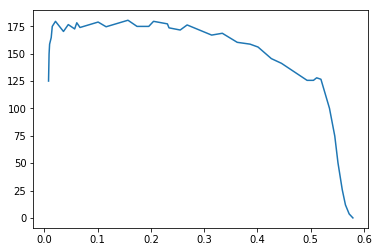

Approximately when does ignition occur: 0
0
When does motor burn end?: 0.578
38


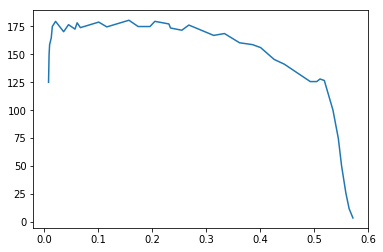

Press q to stop: q


In [4]:
start = 0
end = len(accel)
plt.plot(time[start:end], accel[start:end])
plt.show()
while True:    
    start = np.argmax(time > input("Approximately when does ignition occur: "))
    print start
    end = np.argmax(time > input("When does motor burn end?: "))
    print end
    
    plt.plot(time[start:end], accel[start:end])
    plt.show()
    
    if raw_input("Press q to stop: ") == 'q':
        break        
time = time[start:end] - time[start]
accel = accel[start:end]

#### Model Environment
Acceleration data is used to get velocity, altitude, and air density. Check the graphs for accuracy
<br>
<div align='middle'>
    $v(t)=\int_{start}^{t}{a(t')dt'} + v_0$
    <br>
    $x(t)=\int_{start}^{t}{x(t')dt'} + x_0$
    <br>
    $\rho=\rho_b\bigg[\frac{T_b}{T_b+L_b*(x(t)-x_0)}\bigg]^{1+\frac{g_0\cdot M}{R\cdot L_b}}$

utility.py:22: RuntimeWarning: divide by zero encountered in double_scalars
  rho.extend([1.225 * (288.15 / (288.15 + -0.0065 * x ** (1 + (9.8 * 0.02896) / (8.3145 * -0.0065)))) for x in x_pos[:trop_x]])


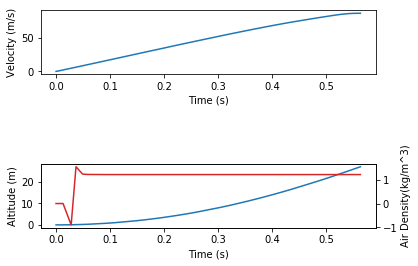

In [5]:
vel, altit, rho = get_data(time, accel)

plt.subplot(311)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.plot(time, vel, label='')

plt.subplot(313)
plt.plot(time, altit, label='altitude', color='tab:blue')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt2 = plt.twinx()
plt2.set_ylabel('Air Density(kg/m^3)')
plt.plot(time, rho, label='air density', color='tab:red')

plt.show()

#### Done!
Using all of the information above we can calculate a *minimum* threshold for spin stability and compare it to the values recorded
<div align='middle'>
    $p>\frac{V}{I_x}\sqrt{2\rho SdC_{M_\alpha}I_y}$

utility.py:35: RuntimeWarning: invalid value encountered in sqrt
  return [vel[i] / rocket[i]['I_x'] * np.sqrt(2 * rho[i] * rocket[i]['I_y'] * rocket[i]['Surface Area'] * rocket[i]['Calipers'] * rocket[i]['Diameter']) for i in range(len(vel))]


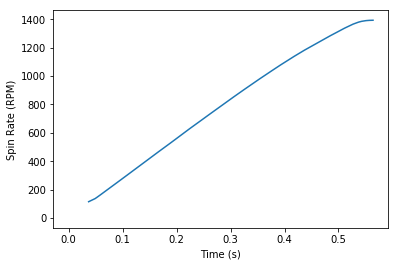

In [6]:
min_spin = get_spin(vel, rho, launch_profile)
min_spin= np.asarray(min_spin) * 9.55

plt.xlabel('Time (s)')
plt.ylabel('Spin Rate (RPM)')
plt.plot(time, min_spin)